<a href="https://colab.research.google.com/github/hmk46/emacspeak/blob/master/kadhem_gsoc23_qmlep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import pennylane as qml
except:
    !pip install pennylane
    import pennylane as qml
from pennylane import numpy as np
try:
    import cirq
except:
    !pip install cirq
    import cirq
import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Linear
try:
    import torch_geometric
except:
    !pip install torch_geometric
    import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, EdgeConv, global_mean_pool, knn_graph
from torch_geometric.transforms import KNNGraph
from torch_geometric.logging import log
try:
    from energyflow import qg_jets
except:
    !pip install energyflow
    from energyflow import qg_jets
import matplotlib.pyplot as plt
from collections import namedtuple
try:
    import torch_cluster
except:
    !pip install torch_cluster
    import torch_cluster
try:
    import torchvision
except:
    !pip install torchvision
    import torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch_geometric-2.3.0.tar.gz (616 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=f5cb4c41f6827a13364d4665e88effb410738a6502a814a199508bf1f519a8d0
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch_geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.5/700.5 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 KB 43.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#Task I

##Part (1)

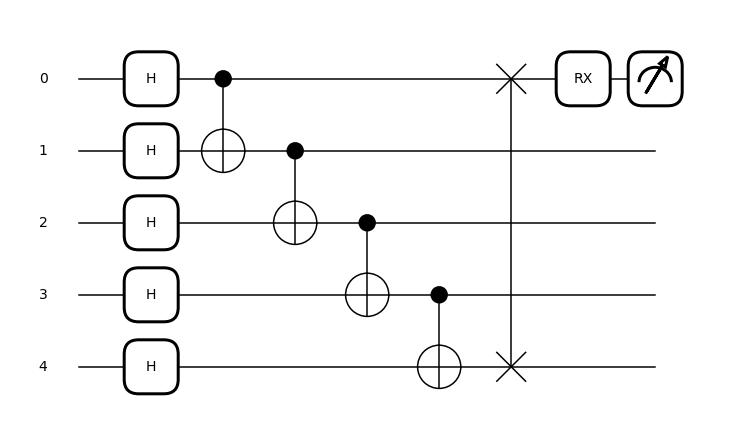

In [2]:
# part (a)
dev = qml.device("default.qubit", wires=5, shots=1000)

@qml.qnode(dev)
def circuit_i1(args):
    # part (b)
    for i in range(5):
        qml.Hadamard(wires=i)
    # part (c)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[2,3])
    qml.CNOT(wires=[3,4])
    # part (d)
    qml.SWAP(wires=[0,4])
    # part (e)
    qml.RX(np.pi/2, 0)
    return qml.expval(qml.PauliZ(0))

# part (f)
fig,ax = qml.draw_mpl(circuit_i1)(0.1)
fig.show()

##Part (2)

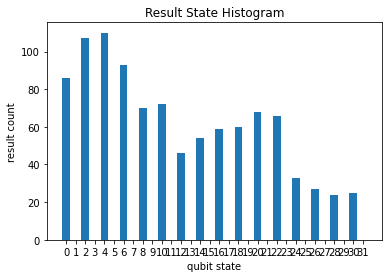

In [3]:
Q = cirq.LineQubit.range(7)
a_1,a_2 = Q[5:]

circuit_i2 = cirq.Circuit([
    # part (a)
    cirq.H(Q[0]),
    # part (b)
    cirq.rx(np.pi/3)(Q[1]),
    # part (c)
    cirq.H(Q[2]),
    cirq.H(Q[3]),
    # part (d)
    cirq.H(a_1),
    cirq.H(a_2),
    cirq.CSWAP(a_1, Q[0], Q[1]),
    cirq.CSWAP(a_2, Q[2], Q[3]),
    cirq.H(a_1),
    cirq.H(a_2),
    cirq.measure(Q[:5])
])

s = cirq.Simulator()
samples = s.run(circuit_i2, repetitions=1000)
cirq.plot_state_histogram(samples, plt.subplot())
plt.show()

#Helper Class

We will use the following helper class in the following tasks to run our models.

In [2]:
class ModelRunner:
    def __init__(self, train_loader, test_loader):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = None

    def train(self):
        self.model.train()
        total_loss = 0
        for data in self.train_loader:
            if self.device:
                data = data.to(self.device)
            self.opt.zero_grad()
            pred = self.train_pred(data)
            loss = self.loss_fn(pred, data.y)
            loss.backward()
            self.opt.step()
            total_loss += float(loss) * data.y.shape[0]
        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def test(self, loader):
        self.model.eval()
        total_correct = 0
        for data in loader:
            if self.device:
                data = data.to(self.device)
            pred = self.test_pred(data)
            total_correct += int((pred == data.y).sum())
        return total_correct / len(loader.dataset)

    def run(self, N_epochs=11, log_freq=10):
        for epoch in range(N_epochs):
            loss = self.train()
            if epoch % log_freq == 0:
                train_acc = self.test(self.train_loader)
                test_acc = self.test(self.test_loader)
                log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)


#Task II

For both models, we will represent the spatial relationships between the particles in a jet using azimuth-rapidity coordinates. These are standard coordinates to use because they are invariant under Lorentz boosts along the beam axis. The models will be trying to learn a graph-level binary label indicating whether the jet is from a quark or gluon.

First we use the energyflow package to load some training data. We also create a model helper class.



In [5]:
N = 2000
N_split = 1000
X_raw,Y_raw = qg_jets.load(num_data=N)


In [6]:
class GCNRunner(ModelRunner):
    def __init__(self, train_loader, test_loader, model):
        super().__init__(train_loader, test_loader)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.train_loader = self.train_loader
        self.test_loader = self.test_loader
        self.model = model.to(self.device)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=1e-3, amsgrad=True)
        self.loss_fn = torch.nn.CrossEntropyLoss()
    def train_pred(self, data):
        return self.model(data)
    def test_pred(self, data):
        return self.model(data).argmax(dim=-1)

##Model 1

For the first model, we will represent the jets by weighted graphs who's edge weights are given by distances in the coordinate plane. We omit the azimuthal angle from the node features to creat invariance under rotation. The model uses a few standard *GcnConv* layers, followed by mean pooling to agregate a graph-level prediction, which is trained using binary cross-entropy loss.

In [7]:
def make_jets_dataset1():
    graphs = []
    for i_jet in range(X_raw.shape[0]):
        vertices = []
        for i_part in range(X_raw.shape[1]):
            pt,y,phi,pid = X_raw[i_jet][i_part]
            if pid == 0:
                break
            vertices.append(Tensor([pt,y,pid]))
        vertices = torch.stack(vertices).contiguous()
        m = vertices.shape[0]
        y = torch.as_tensor(Y_raw[i_jet], dtype=torch.long)
        edges = list(zip(*(
            [i, j, np.hypot(v_i[1]-v_j[1], v_i[2]-v_j[2])]
              for i,v_i in enumerate(X_raw[i_jet][:m])
              for j,v_j in enumerate(X_raw[i_jet][:m]) if i != j
        )))
        edge_index = torch.as_tensor(edges[:2], dtype=torch.long).contiguous()
        edge_attr = torch.as_tensor(edges[2], dtype=torch.float).contiguous()
        graph = Data(
            x=vertices,
            edge_index=edge_index,
            y = y,
            edge_attr=edge_attr)
        graphs.append(graph)
    return graphs

class JetGCN1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 16)
        self.classifier = Linear(16, 2)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_weight=edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight=edge_weight).relu()
        x = global_mean_pool(x, data.batch)
        x = self.classifier(x).softmax(-1)
        return x


In [8]:
jet_graphs_1 = make_jets_dataset1()
model = JetGCN1()
train_loader = DataLoader(jet_graphs_1[:N_split], batch_size=32)
test_loader = DataLoader(jet_graphs_1[N_split:], batch_size=32)
GCNRunner(train_loader, test_loader, model).run(N_epochs=201)

<ipython-input-7-8af0f178b69c>:12: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.as_tensor(Y_raw[i_jet], dtype=torch.long)


Epoch: 000, Loss: 0.7183, Train: 0.6080, Test: 0.5840
Epoch: 010, Loss: 0.6231, Train: 0.6910, Test: 0.6770
Epoch: 020, Loss: 0.5985, Train: 0.7400, Test: 0.7250
Epoch: 030, Loss: 0.5775, Train: 0.7660, Test: 0.7350
Epoch: 040, Loss: 0.5611, Train: 0.7620, Test: 0.7560
Epoch: 050, Loss: 0.5507, Train: 0.7690, Test: 0.7610
Epoch: 060, Loss: 0.5442, Train: 0.7710, Test: 0.7690
Epoch: 070, Loss: 0.5399, Train: 0.7680, Test: 0.7690
Epoch: 080, Loss: 0.5367, Train: 0.7710, Test: 0.7710
Epoch: 090, Loss: 0.5344, Train: 0.7730, Test: 0.7750
Epoch: 100, Loss: 0.5327, Train: 0.7750, Test: 0.7780
Epoch: 110, Loss: 0.5313, Train: 0.7780, Test: 0.7790
Epoch: 120, Loss: 0.5302, Train: 0.7800, Test: 0.7810
Epoch: 130, Loss: 0.5293, Train: 0.7810, Test: 0.7820
Epoch: 140, Loss: 0.5285, Train: 0.7840, Test: 0.7830
Epoch: 150, Loss: 0.5278, Train: 0.7890, Test: 0.7810
Epoch: 160, Loss: 0.5272, Train: 0.7860, Test: 0.7810
Epoch: 170, Loss: 0.5267, Train: 0.7840, Test: 0.7790
Epoch: 180, Loss: 0.5261, Tr

##Model 2

The second model will follow a similar structure, but with a few differences. We will represent jets by unweighted $K$-nearest-neighbor graphs, with distances given in the coordinate planes. This will provide significant performance improvements, as there will be much less entries in the adjacency matrices. The model will instead use a few *EdgeConv* layers to agregate the features from node neighbors, followed by a similar pooling step.

In [9]:
def make_jets_dataset2():
    KNN = KNNGraph()
    graphs = []
    for i_jet in range(X_raw.shape[0]):
        vertices = []
        pos = []
        for i_part in range(X_raw.shape[1]):
            pt,y,phi,pid = X_raw[i_jet][i_part]
            if pid == 0:
                break
            vertices.append(Tensor([pt,y,phi]))
            pos.append(Tensor([y,phi]))
        vertices = torch.stack(vertices).contiguous()
        pos = torch.stack(pos).contiguous()
        y = torch.as_tensor(Y_raw[i_jet], dtype=torch.long)
        graph = Data(
            x=vertices,
            pos=pos,
            y = y)
        graph = KNN(graph)
        graphs.append(graph)
    return graphs

class JetGCN2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Linear(3, 8)
        self.conv2 = EdgeConv(Linear(16, 16), aggr='mean')
        self.classifier = Linear(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, data.batch)
        x = self.classifier(x).softmax(-1)
        return x


In [12]:
jet_graphs_2 = make_jets_dataset2()
model = JetGCN2()
train_loader = DataLoader(jet_graphs_2[:N_split], batch_size=32)
test_loader = DataLoader(jet_graphs_2[N_split:], batch_size=32)
GCNRunner(train_loader, test_loader, model).run(N_epochs=201)

<ipython-input-9-d3fe60cf0f12>:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.as_tensor(Y_raw[i_jet], dtype=torch.long)


Epoch: 000, Loss: 0.6776, Train: 0.5130, Test: 0.5170
Epoch: 010, Loss: 0.5656, Train: 0.7470, Test: 0.7400
Epoch: 020, Loss: 0.5506, Train: 0.7500, Test: 0.7520
Epoch: 030, Loss: 0.5445, Train: 0.7550, Test: 0.7560
Epoch: 040, Loss: 0.5407, Train: 0.7590, Test: 0.7610
Epoch: 050, Loss: 0.5378, Train: 0.7640, Test: 0.7670
Epoch: 060, Loss: 0.5355, Train: 0.7670, Test: 0.7640
Epoch: 070, Loss: 0.5337, Train: 0.7700, Test: 0.7660
Epoch: 080, Loss: 0.5323, Train: 0.7720, Test: 0.7670
Epoch: 090, Loss: 0.5313, Train: 0.7730, Test: 0.7690
Epoch: 100, Loss: 0.5305, Train: 0.7750, Test: 0.7670
Epoch: 110, Loss: 0.5299, Train: 0.7730, Test: 0.7690
Epoch: 120, Loss: 0.5293, Train: 0.7740, Test: 0.7690
Epoch: 130, Loss: 0.5289, Train: 0.7750, Test: 0.7690
Epoch: 140, Loss: 0.5285, Train: 0.7760, Test: 0.7690
Epoch: 150, Loss: 0.5282, Train: 0.7770, Test: 0.7690
Epoch: 160, Loss: 0.5279, Train: 0.7800, Test: 0.7680
Epoch: 170, Loss: 0.5276, Train: 0.7790, Test: 0.7670
Epoch: 180, Loss: 0.5274, Tr

##Comparison

We observe that both models usually achieve a mild level of accuracy (around 80%), with the second sometimes lagging slightly behind. The second model requires much less time to construct the graph representation data, and to run individual layers. This is because there are an order of magnitude less edges to compute, and the adjacency matrices are consequently fairly sparse. However in order to achieve a similar accuracy, the second model needs to have a more complicated architecture, as the nodes need to agregate local neighborhood features in several steps to reach information about far-away nodes. This is important because one of the features which are used to distinguish quark jets from gluon jets is the spread of energy, which is not local information.


#Task III

##What Is Quantum Computing?
At a fundamental level, (qubit) quantum computing is about linearization of the state spaces and processes of classical binary computing.
In classical computing, the basic state space is that of a *bit*, given by the set $\{0, 1\}$.
In quantum computing, we linearize this to obtain the state space of a *qubit*, given by $\mathbb{C}\otimes 0 \oplus \mathbb{C}\otimes 1 = \mathbb{C}^2$.
Logic gates, or observables, between spaces built up of bits are linearized to become self-adjoint linear operators on Hilbert spaces built of qubits.
Mathematically, this is a small part of the larger machinery of representation theory and quantization. It is similar, for example, to the idea of linearizing permutations of sets to obtain permutation matrices.
What makes it so interesting, however?
It is the fact that we have been able to come up with real-life physical systems that can approximate these linear spaces and operators, similar to how we are able to use transistors to simulate digital processes.
This allows us to encode interesting linear-algebraic problems, which might otherwise be hard to solve using classical systems, as physical systems which can be evolved and measured to obtain solutions.
For example, the problem of finding the minimum eigenvalue of a Hermitian matrix can equivalently be formulated as finding the ground state of a quantum system evolving under the corresponding Hamiltonian.

There is a big complication in this setup, however.
Unlike in classical systems, measurement of quantum systems is very tricky. They are much more sensitive to interactions and entanglement with their environment, and any implementation of a quantum computing process needs to minimize the resulting noise in order for the outputs to be useful.

##What is Quantum Machine Learning?
QML can refer to two kinds of learning problems, though they are not always entirely separate.

In the first, we wish to execute a learning model that is otherwise classical, but it involves some computationally difficult linear algebra.
If we can find a way to transform this linear algebra into the structure of a quantum system, then we might be able to use quantum computing techniques to speed up the model significantly.

In the second, we wish to execute a model to learn some properties of a physical system which is quantum mechanical in nature.
For example, classifying fundamental particles in an accelerator, or simulating electron interactions in a material.
It is often the case that accurately computing the quantum mechanics of these systems is very intensive. If we can approximate them by a system of qubits and quantum gates, then we can measure the physical properties we need directly rather than relying on expensive simulations.


##Potential Work
One project idea I would be interested in working on is implementing graph neural network algorithms for classifying particle jets,
but using equivariant quantum circuits that respect natural continuous symmetries such as Lorentz boosts or $\operatorname{SU}(2)$.

#Task V

We will use the unweighted nearest-neighbor graph representation from the second model of part II.
We can consider the graph as representing an Ising Hamiltonian with learnable angles, where edges indicate coupled qubits.
The features $p_t,y,\phi$ of each vertex are embedded as initial $R_Z,R_X,R_Y$ angles.
Finally, we read out a prediction from a $\operatorname{CSwap}$ layer that swaps along the graph edges.

In [13]:
def QGNNLayer(Theta_1, Theta_2, edges=None, delta=None):
    # Apply RZZ gates
    for i, (s_i, t_i) in enumerate(edges):
        qml.MultiRZ(Theta_1[i] *delta, wires=(s_i.item(), t_i.item()))
    # Apply RZ gates
    for i,Theta_2_i in enumerate(Theta_2):
        qml.RZ(Theta_2_i * delta, wires=i)
    # Apply RX gates
    for i,_ in enumerate(Theta_2):
        qml.RX(delta, wires=i)
def QGNNCircuit(Theta_1, Theta_2, vertices=None, edges=None, delta=None, control=None):
    # Embed each node's (pt,y,\phi) data as rotation angles
    for i,v_i in enumerate(vertices):
        qml.RZ(v_i[0], wires=i)
        qml.RX(v_i[1], wires=i)
        qml.RY(v_i[2], wires=i)
    qml.layer(QGNNLayer, Theta_1.shape[0], Theta_1, Theta_2, edges=edges, delta=delta)
    # Entangle all the nodes and read out the control qubit as the prediction.
    qml.Hadamard(control)
    for s_i,t_i in edges:
        qml.CSWAP((control, s_i.item(), t_i.item()))
    qml.Hadamard(control)
    return qml.expval(qml.PauliZ(control))


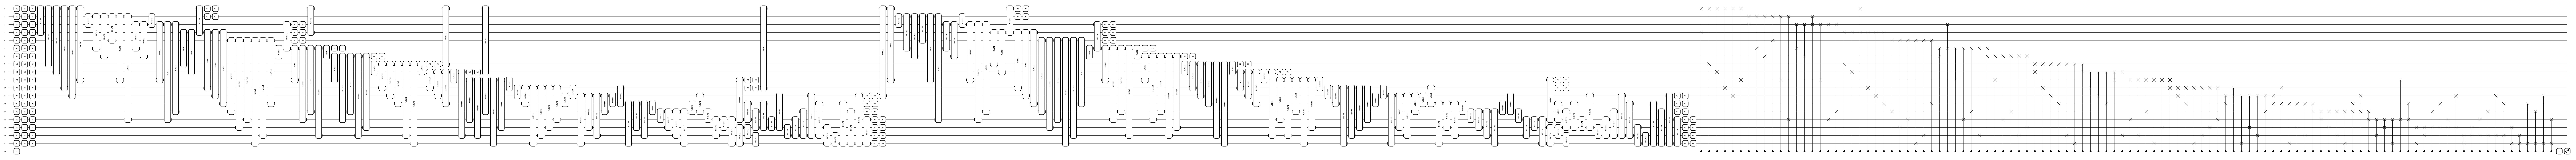

In [14]:
graph = jet_graphs_2[0]
vertices = graph.x
edges = graph.edge_index.T
control = len(vertices)
N_layers=2
Theta_1 = torch.empty((N_layers, len(edges)))
Theta_2 = torch.empty((N_layers, len(vertices)))
delta = 1e-1
torch.nn.init.uniform_(Theta_1)
torch.nn.init.uniform_(Theta_2)
qubits = qml.device("default.qubit", wires=control+1, shots=1000)
qnode = qml.QNode(QGNNCircuit, qubits, interface="torch")
fig,ax = qml.draw_mpl(qnode)(Theta_1, Theta_2, vertices, edges, delta, control)
fig.show()

#Task VI

First we load a small subset of MNIST, and do some rangling on it that is required to fit into the pennylane training framework we are using.

In [3]:
def make_contrastive_data(data):
    out = []
    Sample = namedtuple("Sample", ("x","y"))
    for datum1 in data:
        for datum2 in data:
            x = torch.cat((datum1[0].flatten().to(torch.float64), datum2[0].flatten().to(torch.float64)))
            y = np.float64(1) if datum1[1] == datum2[1] else np.float64(-1)
            out.append(Sample(x,y))
    return out



In [4]:
MNIST_train = torchvision.datasets.MNIST('./', transform=torchvision.transforms.ToTensor(), train=True, download=True)
MNIST_test = torchvision.datasets.MNIST('./', transform=torchvision.transforms.ToTensor(), train=False, download=True)
N_train = 100
N_test = 100
train_data,_ = torch.utils.data.random_split(MNIST_train, [N_train, len(MNIST_train)-N_train])
test_data,_ = torch.utils.data.random_split(MNIST_test, [N_test, len(MNIST_test)-N_test])
train_data = make_contrastive_data(train_data)
test_data = make_contrastive_data(test_data)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=32)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



To create a representation with learnable parameters, we first perform an amplitude embedding of each image (784 pixels) into 10 qubits, followed by an application of rotations to each qubit. The angles of the rotations are what are used as the model weights.

In [5]:
class QRepLearnRunner(ModelRunner):
    def __init__(self, train_loader, test_loader):
        super().__init__(train_loader, test_loader)
        dev = qml.device("lightning.qubit", wires=21, shots=10)
        def prepare_image(weights, img=None, qubits=None):
            qml.AmplitudeEmbedding(img, qubits, pad_with=0, normalize=True)
            for i,q_i in enumerate(qubits):
                qml.Rot(*weights[i], q_i)
        @qml.qnode(dev, interface="torch")
        @qml.transforms.merge_amplitude_embedding
        def circuit(weights_1, weights_2, inputs=None):
            img_1, img_2 = inputs.reshape(2,-1)
            prepare_image(weights_1, img_1, range(10))
            prepare_image(weights_2, img_2, range(10,20))
            qml.Hadamard(20)
            for i in range(10):
                qml.CSWAP((20, i, i+10))
            qml.Hadamard(20)
            return qml.expval(qml.PauliZ(20))
        weight_shapes = { "weights_1" : (10, 3), "weights_2" : (10, 3) }
        qlayer = qml.qnn.TorchLayer(circuit, weight_shapes=weight_shapes)
        self.model = torch.nn.Sequential(qlayer)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-8, amsgrad=True)
        self.loss_fn = torch.nn.MSELoss()
    def train_pred(self, data):
        return self.model(data.x)
    def test_pred(self, data):
        return self.model(data.x).sign()



Finally we run the model. Note that the simulation is very slow due to the high number of qubits and gates applied.

In [ ]:
QRepLearnRunner(train_loader, test_loader).run(N_epochs=10, log_freq=1)

#Task VII

##Part 1

We first write a function to generate a training dataset with $\mathbb{Z}_2 \times \mathbb{Z}_2$ equivariance. A simple algebraic structure obeying this symmetry is multiplication $(x,y) \mapsto x \cdot y$. A natural binary classification on this structure is whether $x \cdot y \geq 0$.

In [48]:
def generate_klein4inv_data(N, N_split):
    dataset = []
    Sample = namedtuple('Sample', ('x','y'))
    for n in range(N):
        v = 2*torch.rand(2, requires_grad=False)-1
        feature = v
        c = 1 if v[0]*v[1] >= 0 else -1
        dataset.append(Sample(feature, torch.as_tensor(c, dtype=torch.float)))
    return dataset[:N_split], dataset[N_split:]

In [50]:
train_data, test_data = generate_klein4inv_data(200, 100)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)


##Helper Class
Next we define a class to help us run the different QNN. These are parameterized by trainable weights `Theta` which will have dimension of the size of the generating gate set.

In [51]:
class QNNRunner(ModelRunner):
    def __init__(self, train_loader, test_loader, circuit_layer, N_Theta, N_layers=1):
        super().__init__(train_loader, test_loader)
        dev = qml.device('lightning.qubit', wires=2, shots=1000)
        @qml.qnode(dev, interface="torch")
        def circuit(Theta, inputs=None):
            qml.AngleEmbedding(features=inputs, wires=(0,1), rotation='X')
            qml.layer(circuit_layer, N_layers, Theta)
            return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))
        weight_shapes = { "Theta" : (N_layers, N_Theta)}
        qlayer = qml.qnn.TorchLayer(circuit, weight_shapes=weight_shapes)
        self.model = torch.nn.Sequential(qlayer)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-8, amsgrad=True)
        self.loss_fn = torch.nn.MSELoss()
    def train_pred(self, data):
        return self.model(data.x)
    def test_pred(self, data):
        return self.model(data.x).sign()



##Part 2

The layers of the non-equivariant QNN are parameterized by $6$ rotation weights, and $1$ $R_{ZZ}$ entangling gate.

In [45]:
def circuit_layer(Theta):
    qml.Rot(*Theta[:3], wires=0)
    qml.Rot(*Theta[3:6], wires=1)
    qml.IsingZZ(Theta[6], (0,1))

In [52]:
QNNRunner(train_loader, test_loader, circuit_layer, 7, N_layers=4).run(N_epochs=21, log_freq=1)


Epoch: 000, Loss: 1.2423, Train: 0.6500, Test: 0.4600
Epoch: 001, Loss: 1.2418, Train: 0.6600, Test: 0.4700
Epoch: 002, Loss: 1.2317, Train: 0.6500, Test: 0.4600
Epoch: 003, Loss: 1.2276, Train: 0.6600, Test: 0.4600
Epoch: 004, Loss: 1.2097, Train: 0.6500, Test: 0.4700
Epoch: 005, Loss: 1.2204, Train: 0.6400, Test: 0.4600
Epoch: 006, Loss: 1.1926, Train: 0.6500, Test: 0.4700


KeyboardInterrupt: ignored

##Part 3

The equivariant QNN has a restricted gateset of $\{ (X_1+X_2)/2, Z_1\otimes Z_2\}$. So its weights have a dimension of $2$.

In [53]:
def circuit_layer_equiv(Theta):
    qml.RX(Theta[0]/2, 0)
    qml.RX(Theta[0]/2, 1)
    qml.IsingZZ(Theta[1], (0,1))

In [54]:
QNNRunner(train_loader, test_loader, circuit_layer_equiv, 2, N_layers=4).run(N_epochs=21, log_freq=1)

Epoch: 000, Loss: 0.8089, Train: 0.6700, Test: 0.5000
Epoch: 001, Loss: 0.8048, Train: 0.6700, Test: 0.4800
Epoch: 002, Loss: 0.8072, Train: 0.6800, Test: 0.4900
Epoch: 003, Loss: 0.7969, Train: 0.6800, Test: 0.5000
Epoch: 004, Loss: 0.7915, Train: 0.6800, Test: 0.4900
Epoch: 005, Loss: 0.7851, Train: 0.6800, Test: 0.4900
Epoch: 006, Loss: 0.7800, Train: 0.6800, Test: 0.4800
Epoch: 007, Loss: 0.7774, Train: 0.6800, Test: 0.5200
Epoch: 008, Loss: 0.7706, Train: 0.6900, Test: 0.5100
Epoch: 009, Loss: 0.7773, Train: 0.6900, Test: 0.5100
Epoch: 010, Loss: 0.7680, Train: 0.6900, Test: 0.5100
Epoch: 011, Loss: 0.7710, Train: 0.6900, Test: 0.4900
Epoch: 012, Loss: 0.7659, Train: 0.6800, Test: 0.5400
Epoch: 013, Loss: 0.7611, Train: 0.6900, Test: 0.5200
Epoch: 014, Loss: 0.7522, Train: 0.7000, Test: 0.5400
Epoch: 015, Loss: 0.7630, Train: 0.6800, Test: 0.5100
Epoch: 016, Loss: 0.7524, Train: 0.6900, Test: 0.5400
Epoch: 017, Loss: 0.7495, Train: 0.6800, Test: 0.5400
Epoch: 018, Loss: 0.7447, Tr

##Comparison

We observe that the equivariant QNN does usually appear to perform better, though the training set is too small to perhaps draw difinitive conclusions. Even when the non-equivariant QNN reaches similar levels of accuracy, its cost still lags behind, indicating that the equivariant QNN is more rapidly converging to more confident predictions. It is also several factors facter in training time, since the circuit is much less complex.